In [140]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [146]:
class GridWorld:
    def __init__(self, grid_size=5, wind=0.2):
        # (0,0) bottom left corner (x,y)
        self.names = ["Right", "Down", "Left", "Up"]
        self.actions = [(1,0),(0,1),(-1,0),(0,-1)]
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.wind = float(wind)
        
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))

        self.features = np.eye(self.n_states)
    
        self.state = 0


    def reward(self, state_p):
        return 1 if state_p == self.n_states-1 else 0
        

    def reset(self):
        self.state = 0
        return self.state


    def step(self, a):
        probs = np.zeros(self.n_states)
        for s_p in range(self.n_states):
            probs[s_p] = self.dynamics(s_p, a, self.state)

        self.state = np.random.choice(self.n_states, p=probs)
        return self.state


    def dynamics(self, s_p, a, s):
        x_a, y_a = self.actions[a]
        x, y = s%self.grid_size, s//self.grid_size
        x_p, y_p = s_p%self.grid_size, s_p//self.grid_size

        if not (0 <= x_p < self.grid_size and 0 <= y_p < self.grid_size):
            return 0.0
        if not (0 <= x < self.grid_size and 0 <= y < self.grid_size):
            return 0.0

        if abs(x-x_p) + abs(y-y_p) > 1:
            return 0.0

        if (x+x_a, y+y_a) == (x_p, y_p):
            return 1 - self.wind + self.wind/self.n_actions

        if (x, y) == (x_p, y_p):
            if not (0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size):
                if (x,y) in [(0,0), (0,self.grid_size-1), (self.grid_size-1,0), (self.grid_size-1,self.grid_size-1)]:
                    return 1 - self.wind + 2*self.wind/self.n_actions
                else:
                    return 1 - self.wind + self.wind/self.n_actions
            else:
                if (x,y) in [(0,0), (0,self.grid_size-1), (self.grid_size-1,0), (self.grid_size-1,self.grid_size-1)]:
                    return 2 * self.wind/self.n_actions
                elif x == 0 or x == self.grid_size-1 or y == 0 or y == self.grid_size-1:
                    return self.wind/self.n_actions
                else:
                    return 0.0
       
        return self.wind/self.n_actions

    
    def test(self):
        for s in range(self.n_states):
            print("/// State: ", s)
            for a in range(self.n_actions):
                print("/// Action: ", self.names[a])
                probs = np.zeros((self.grid_size*self.grid_size))
                for s_p in range(self.n_states):
                    probs[s_p] = self.dynamics(s_p, a, s)
                print(probs.reshape(-1, self.grid_size))


    def optimal_policy(self, state):
        x, y = state%self.grid_size, state//self.grid_size
        if x > y:
            return 1
        elif x < y:
            return 0
        else:
            return np.random.randint(2)


    def generate_trajectories(self, num, length, policy=None):
        if not policy:
            policy = self.optimal_policy

        trajs = []
        for n in range(num):
            t = []
            state = self.reset()
            for i in range(length):
                action = policy(state)
                state_p = self.step(action)
                t.append([state, action])
                state = state_p
            trajs.append(t)
        return np.array(trajs)

In [147]:
def value_iteration(threshold, env, rewards, discount=0.01):
    transition = env.dynamics
    V = np.zeros(env.n_states)
    delta = np.inf

    while delta > threshold:
        delta = 0
        for s in range(env.n_states):
            max_v = -np.inf
            for a in range(env.n_actions):
                probs = np.zeros((env.n_states))
                for s_p in range(env.n_states):
                    probs[s_p] = transition(s_p, a, s)
                max_v = max(max_v, np.dot(probs, rewards + discount * V))
            delta = max(delta, abs(V[s] - max_v))
            V[s] = max_v

    policy = np.zeros((env.n_states, env.n_actions))
    for s in range(env.n_states):
        idx = None
        max_v = -np.inf
        for a in range(env.n_actions):
            probs = np.zeros((env.n_states))
            for s_p in range(env.n_states):
                probs[s_p] = transition(s_p, a, s)
            policy[s, a] = np.dot(probs, rewards + discount * V)

    policy = policy - policy.max(axis=1, keepdims=True)
    exps = np.exp(policy)
    policy = exps / exps.sum(axis=1, keepdims=True)
    return policy

In [148]:
class MaximumEntropy:
    def __init__(self, env, trajectories, features, lr=0.01, discount=0.01):
        self.env = env
        self.features = features
        self.trajectories = trajectories
        self.num_t = trajectories.shape[0]
        self.len_t = trajectories.shape[1]

        self.theta = np.random.uniform(size=(env.n_states,))
        self.discount = discount
        self.lr = lr


    def expected_features(self):
        exp_f = np.zeros_like(self.features[0])
        for traj in self.trajectories:
            for s, *_ in traj:
                exp_f += self.features[s]
        return exp_f / self.num_t


    def expected_state_visitation_frequency(self, policy):
        # probability of visiting the initial state
        prob_initial_state = np.zeros(self.env.n_states)
        for traj in self.trajectories:
            prob_initial_state[traj[0, 0]] += 1.0
        prob_initial_state = prob_initial_state / self.num_t

        # Compute 𝜇
        mu = np.repeat([prob_initial_state], self.len_t, axis=0)
        for t in range(1, self.len_t):
            mu[t, :] = 0
            for s in range(self.env.n_states):
                for a in range(self.env.n_actions):
                    for s_p in range(self.env.n_states):
                        mu[t, s] += mu[t-1, s_p] * policy[s_p, a] * self.env.dynamics(s_p, a, s)
        return mu.sum(axis=0)


    def train(self, n_epochs):
        exp_f = self.expected_features()

        for i in tqdm(range(n_epochs)):
            rewards = self.features.dot(self.theta)
            policy = value_iteration(self.discount, self.env, rewards)
            exp_svf = self.expected_state_visitation_frequency(policy)

            grads = exp_f - exp_svf @ self.features
            self.theta += self.lr * grads

        return self.features.dot(self.theta)

In [155]:
grid_size = 5
random_rate = 0.2
num_trajectories = 20
len_trajectory = 15

n_epochs = 200
discount = 0.01
lr = 0.01

In [156]:
gw = GridWorld(grid_size, random_rate)
trajs = gw.generate_trajectories(num_trajectories, len_trajectory)
features = np.eye(gw.n_states)

In [157]:
me = MaximumEntropy(gw, trajs, features, lr, discount)
rewards = me.train(n_epochs)

100%|██████████| 200/200 [00:23<00:00,  8.45it/s]


In [158]:
true_rewards = np.array([gw.reward(s) for s in range(grid_size*grid_size)]).reshape(grid_size, grid_size)

In [159]:
rewards = rewards.reshape(grid_size, grid_size)

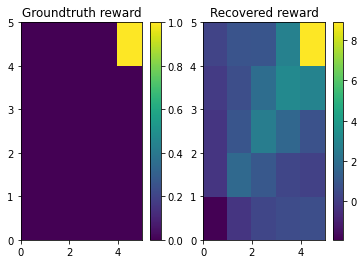

In [160]:
plt.subplot(1, 2, 1)
plt.pcolor(true_rewards)
plt.colorbar()
plt.title("Real reward")
plt.subplot(1, 2, 2)
plt.pcolor(rewards)
plt.colorbar()
plt.title("Generated reward")
plt.show()